In [1]:
using ProgressMeter

In [2]:
using RegularizedSystems
using VSTom
using PyPlot

In [3]:
dw = read_ncdf("/home/lstagner/Dropbox/Inversion_method_analysis/Asger\ source\ code/31557_dW.nc")
a = read_ncdf("/home/lstagner/Dropbox/Inversion_method_analysis/Asger\ source\ code/31557_August_5.nc")

Dict{String,Any} with 4 entries:
  "transfer_matrix_before" => [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 …
  "E"                      => [20.0,21.632652282714844,23.26530647277832,24.897…
  "transfer_matrix_after"  => [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 …
  "p"                      => [-0.9599999785423279,-0.9208163022994995,-0.88163…

In [4]:
energy_full_dA = dw["E"]
pitch_full_dA = dw["p"]
dA_full = dw["dW"]/(abs(energy_full_dA[2]-energy_full_dA[1])*abs(pitch_full_dA[2]-pitch_full_dA[1]))

energy_full_A = a["E"]
pitch_full_A = a["p"]
A_b_full = a["transfer_matrix_before"]/(abs(energy_full_A[2]-energy_full_A[1])*abs(pitch_full_A[2]-pitch_full_A[1]))
A_a_full = a["transfer_matrix_after"]/(abs(energy_full_A[2]-energy_full_A[1])*abs(pitch_full_A[2]-pitch_full_A[1]));

In [5]:
nenergy = 20
npitch = 20

energy = linspace(20.0,100.0,nenergy)
pitch = linspace(extrema(pitch_full_A)...,npitch)
dE = abs(energy[2]-energy[1])
dP = abs(pitch[2]-pitch[1])

dA = resize_transfer_matrix(dA_full,energy_full_dA,pitch_full_dA,energy,pitch)
A_b = resize_transfer_matrix(A_b_full,energy_full_A,pitch_full_A,energy,pitch)
A_a = resize_transfer_matrix(A_a_full,energy_full_A,pitch_full_A,energy,pitch);

In [6]:
data_b = read_ncdf("data/before_sawtooth_data.cdf")
data_a = read_ncdf("data/after_sawtooth_data.cdf")
spec_b = data_b["spectra"]
err_b = data_b["error"]
spec_a = data_a["spectra"]
err_a = data_a["error"];

In [7]:
true_dist = read_ncdf("data/true_sawtooth_distributions.cdf");
true_before = bilinear(true_dist["TRANSP_before"],true_dist["E"],true_dist["p"],energy,pitch)
true_after = bilinear(true_dist["TRANSP_after"],true_dist["E"],true_dist["p"],energy,pitch);

In [35]:
nr,nc = size(A_a)
num=25
x_a_samples = zeros(nc,num)
x_b_samples = zeros(nc,num)
@showprogress for i=1:num
    rA_b = A_b .+ dA.*randn(size(A_b)...)
    rA_a = A_a .+ dA.*randn(size(A_a)...)
    rspec_b = spec_b .+ err_b.*randn(size(spec_b)...)
    rspec_a = spec_a .+ err_a.*randn(size(spec_a)...)

    tsvd_before = TSVDFunctional(rA_b,rspec_b,err_b);
    tsvd_after  = TSVDFunctional(rA_a,rspec_a,err_a);
    k_before = discrete_lcurve(tsvd_before,55:75,nseeds=20)
    k_after = discrete_lcurve(tsvd_after,55:75,nseeds=20)
    sol_b = minimize(tsvd_before,k_before)
    sol_a = minimize(tsvd_after,k_after)
    x_b_samples[:,i] = max(sol_b.x,0)/(dE*dP)
    x_a_samples[:,i] = max(sol_a.x,0)/(dE*dP)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


In [39]:
tsvd_b_mean = reshape(mean(x_b_samples,2),20,20)
tsvd_b_var  = reshape(var(x_b_samples,2),20,20)
tsvd_b_bias = tsvd_b_mean .- true_before

tsvd_a_mean = reshape(mean(x_a_samples,2),20,20)
tsvd_a_var  = reshape(var(x_a_samples,2),20,20)
tsvd_a_bias = tsvd_a_mean .- true_after

tsvd_ratio_mean = reshape(mean(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)
tsvd_ratio_var = reshape(var(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)

iratio_samples = zeros(20,25)
for i=1:num
    iratio_samples[:,i] = sum(reshape(x_a_samples[:,i],20,20),2)./sum(reshape(x_b_samples[:,i],20,20),2)
end

tsvd_iratio_mean = squeeze(mean(iratio_samples,2),2)
tsvd_iratio_var = squeeze(var(iratio_samples,2),2);

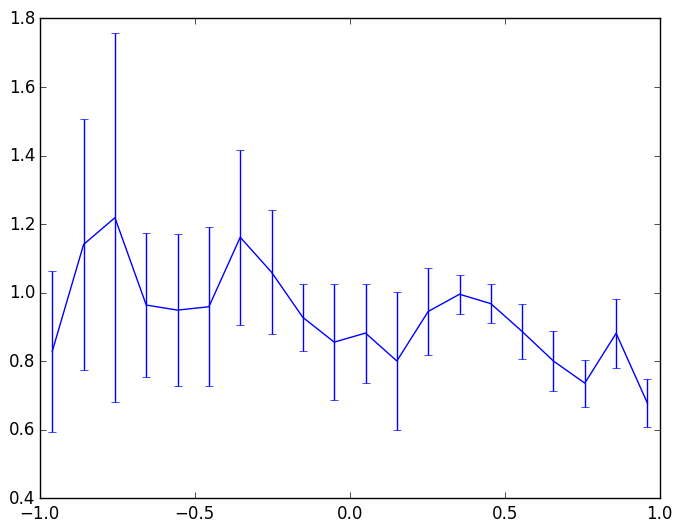

(PyObject <matplotlib.lines.Line2D object at 0x7fbafb8cbb70>,(PyObject <matplotlib.lines.Line2D object at 0x7fbafb8c6fd0>,PyObject <matplotlib.lines.Line2D object at 0x7fbafb8cb3c8>),(PyObject <matplotlib.collections.LineCollection object at 0x7fbafb8c65f8>,))

In [40]:
errorbar(pitch,tsvd_iratio_mean,sqrt(tsvd_iratio_var))

In [41]:
using NetCDF
# Write synthetic data to file
fname = "data/tsvd_sampled_sawtooth.cdf"

isfile(fname) && rm(fname)

nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_a_mean_varid = NcVar("x_a_mean",[np_id,nen_id])
x_a_var_varid = NcVar("x_a_var",[np_id,nen_id])
x_a_bias_varid = NcVar("x_a_bias",[np_id,nen_id])

x_b_mean_varid = NcVar("x_b_mean",[np_id,nen_id])
x_b_var_varid = NcVar("x_b_var",[np_id,nen_id])
x_b_bias_varid = NcVar("x_b_bias",[np_id,nen_id])

x_ratio_mean_varid = NcVar("ratio_mean",[np_id,nen_id])
x_ratio_var_varid = NcVar("ratio_var",[np_id,nen_id])

iratio_mean_varid = NcVar("iratio_mean",np_id)
iratio_var_varid = NcVar("iratio_var",np_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[x_a_mean_varid,x_a_var_varid,x_a_bias_varid,
    x_b_mean_varid,x_b_var_varid,x_b_bias_varid,
    x_ratio_mean_varid,x_ratio_var_varid,
    iratio_mean_varid,iratio_var_varid,
    energy_varid,pitch_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_b_mean",tsvd_b_mean)
NetCDF.putvar(ncid,"x_b_var",tsvd_b_var)
NetCDF.putvar(ncid,"x_b_bias",tsvd_b_bias)

NetCDF.putvar(ncid,"x_a_mean",tsvd_a_mean)
NetCDF.putvar(ncid,"x_a_var",tsvd_a_var)
NetCDF.putvar(ncid,"x_a_bias",tsvd_a_bias)

NetCDF.putvar(ncid,"ratio_mean",tsvd_ratio_mean)
NetCDF.putvar(ncid,"ratio_var",tsvd_ratio_var)

NetCDF.putvar(ncid,"iratio_mean",tsvd_iratio_mean)
NetCDF.putvar(ncid,"iratio_var",tsvd_iratio_var)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid);

In [30]:
nr,nc = size(A_a)
num=25
x_a_samples = zeros(nc,num)
x_b_samples = zeros(nc,num)
@showprogress for i=1:num
    rA_b = A_b .+ dA.*randn(size(A_b)...)
    rA_a = A_a .+ dA.*randn(size(A_a)...)
    rspec_b = spec_b .+ err_b.*randn(size(spec_b)...)
    rspec_a = spec_a .+ err_a.*randn(size(spec_a)...)

    tik0_before = TikhonovFunctional(rA_b,rspec_b,err_b,(eye(nc),));
    tik0_after  = TikhonovFunctional(rA_a,rspec_a,err_a,(eye(nc),));
    alpha_before = lcurve(tik0_before,log_alpha_range=(-10,5),nseeds=20)
    alpha_after = lcurve(tik0_after,log_alpha_range=(-10,5),nseeds=20)
    sol_b = minimize(tik0_before,alpha_before)
    sol_a = minimize(tik0_after,alpha_after)
    x_b_samples[:,i] = max(sol_b.x,0)/(dE*dP)
    x_a_samples[:,i] = max(sol_a.x,0)/(dE*dP)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:23


In [31]:
tik0_b_mean = reshape(mean(x_b_samples,2),20,20)
tik0_b_var  = reshape(var(x_b_samples,2),20,20)
tik0_b_bias = tik0_b_mean .- true_before

tik0_a_mean = reshape(mean(x_a_samples,2),20,20)
tik0_a_var  = reshape(var(x_a_samples,2),20,20)
tik0_a_bias = tik0_a_mean .- true_after

tik0_ratio_mean = reshape(mean(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)
tik0_ratio_var = reshape(var(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)

iratio_samples = zeros(20,25)
for i=1:num
    iratio_samples[:,i] = sum(reshape(x_a_samples[:,i],20,20),2)./sum(reshape(x_b_samples[:,i],20,20),2)
end

tik0_iratio_mean = squeeze(mean(iratio_samples,2),2)
tik0_iratio_var = squeeze(var(iratio_samples,2),2);

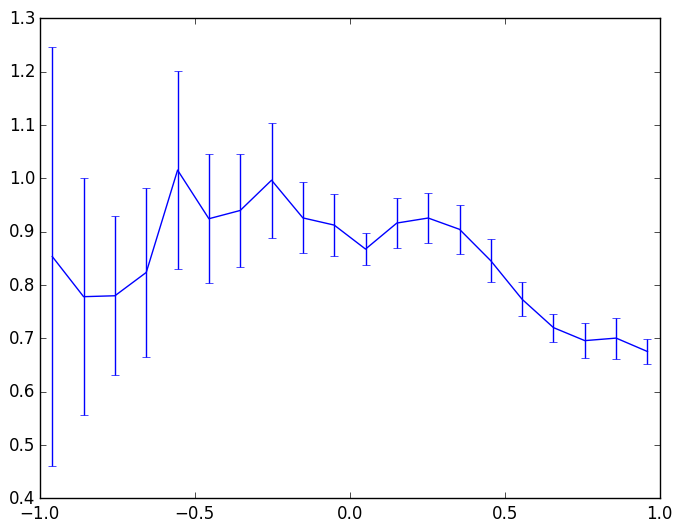

(PyObject <matplotlib.lines.Line2D object at 0x7fbafb981dd8>,(PyObject <matplotlib.lines.Line2D object at 0x7fbafb981278>,PyObject <matplotlib.lines.Line2D object at 0x7fbafb981630>),(PyObject <matplotlib.collections.LineCollection object at 0x7fbafb97b860>,))

In [32]:
errorbar(pitch,tik0_iratio_mean,sqrt(tik0_iratio_var))

In [33]:
using NetCDF
# Write synthetic data to file
fname = "data/tik0_sampled_sawtooth.cdf"

isfile(fname) && rm(fname)

nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_a_mean_varid = NcVar("x_a_mean",[np_id,nen_id])
x_a_var_varid = NcVar("x_a_var",[np_id,nen_id])
x_a_bias_varid = NcVar("x_a_bias",[np_id,nen_id])

x_b_mean_varid = NcVar("x_b_mean",[np_id,nen_id])
x_b_var_varid = NcVar("x_b_var",[np_id,nen_id])
x_b_bias_varid = NcVar("x_b_bias",[np_id,nen_id])

x_ratio_mean_varid = NcVar("ratio_mean",[np_id,nen_id])
x_ratio_var_varid = NcVar("ratio_var",[np_id,nen_id])

iratio_mean_varid = NcVar("iratio_mean",np_id)
iratio_var_varid = NcVar("iratio_var",np_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[x_a_mean_varid,x_a_var_varid,x_a_bias_varid,
    x_b_mean_varid,x_b_var_varid,x_b_bias_varid,
    x_ratio_mean_varid,x_ratio_var_varid,
    iratio_mean_varid,iratio_var_varid,
    energy_varid,pitch_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_b_mean",tik0_b_mean)
NetCDF.putvar(ncid,"x_b_var",tik0_b_var)
NetCDF.putvar(ncid,"x_b_bias",tik0_b_bias)

NetCDF.putvar(ncid,"x_a_mean",tik0_a_mean)
NetCDF.putvar(ncid,"x_a_var",tik0_a_var)
NetCDF.putvar(ncid,"x_a_bias",tik0_a_bias)

NetCDF.putvar(ncid,"ratio_mean",tik0_ratio_mean)
NetCDF.putvar(ncid,"ratio_var",tik0_ratio_var)

NetCDF.putvar(ncid,"iratio_mean",tik0_iratio_mean)
NetCDF.putvar(ncid,"iratio_var",tik0_iratio_var)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid);

In [22]:
nr,nc = size(A_a)
num=25
x_a_samples = zeros(nc,num)
x_b_samples = zeros(nc,num)
L1E,L1p = gradEP(energy,pitch)
@showprogress for i=1:num
    rA_b = A_b .+ dA.*randn(size(A_b)...)
    rA_a = A_a .+ dA.*randn(size(A_a)...)
    rspec_b = spec_b .+ err_b.*randn(size(spec_b)...)
    rspec_a = spec_a .+ err_a.*randn(size(spec_a)...)

    tik1_before = TikhonovFunctional(rA_b,rspec_b,err_b,(L1E,L1p));
    tik1_after  = TikhonovFunctional(rA_a,rspec_a,err_a,(L1E,L1p));
    alpha_before = lcurve(tik1_before,log_alpha_range=(0,20),nseeds=20)
    alpha_after = lcurve(tik1_after,log_alpha_range=(0,20),nseeds=20)
    sol_b = minimize(tik1_before,alpha_before)
    sol_a = minimize(tik1_after,alpha_after)
    x_b_samples[:,i] = max(sol_b.x,0)/(dE*dP)
    x_a_samples[:,i] = max(sol_a.x,0)/(dE*dP)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:27


In [27]:
tik1_b_mean = reshape(mean(x_b_samples,2),20,20)
tik1_b_var  = reshape(var(x_b_samples,2),20,20)
tik1_b_bias = tik1_b_mean .- true_before

tik1_a_mean = reshape(mean(x_a_samples,2),20,20)
tik1_a_var  = reshape(var(x_a_samples,2),20,20)
tik1_a_bias = tik1_a_mean .- true_after

tik1_ratio_mean = reshape(mean(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)
tik1_ratio_var = reshape(var(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)

iratio_samples = zeros(20,25)
for i=1:num
    iratio_samples[:,i] = sum(reshape(x_a_samples[:,i],20,20),2)./sum(reshape(x_b_samples[:,i],20,20),2)
end

tik1_iratio_mean = squeeze(mean(iratio_samples,2),2)
tik1_iratio_var = squeeze(var(iratio_samples,2),2);

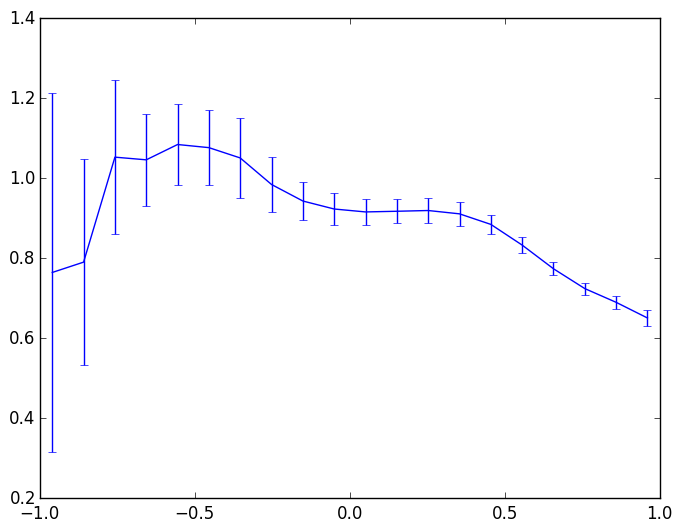

(PyObject <matplotlib.lines.Line2D object at 0x7fbafb99f2e8>,(PyObject <matplotlib.lines.Line2D object at 0x7fbafb999748>,PyObject <matplotlib.lines.Line2D object at 0x7fbafb999b00>),(PyObject <matplotlib.collections.LineCollection object at 0x7fbafba11d30>,))

In [28]:
errorbar(pitch,tik1_iratio_mean,sqrt(tik1_iratio_var))

In [29]:
using NetCDF
# Write synthetic data to file
fname = "data/tik1_sampled_sawtooth.cdf"

isfile(fname) && rm(fname)

nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_a_mean_varid = NcVar("x_a_mean",[np_id,nen_id])
x_a_var_varid = NcVar("x_a_var",[np_id,nen_id])
x_a_bias_varid = NcVar("x_a_bias",[np_id,nen_id])

x_b_mean_varid = NcVar("x_b_mean",[np_id,nen_id])
x_b_var_varid = NcVar("x_b_var",[np_id,nen_id])
x_b_bias_varid = NcVar("x_b_bias",[np_id,nen_id])

x_ratio_mean_varid = NcVar("ratio_mean",[np_id,nen_id])
x_ratio_var_varid = NcVar("ratio_var",[np_id,nen_id])

iratio_mean_varid = NcVar("iratio_mean",np_id)
iratio_var_varid = NcVar("iratio_var",np_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[x_a_mean_varid,x_a_var_varid,x_a_bias_varid,
    x_b_mean_varid,x_b_var_varid,x_b_bias_varid,
    x_ratio_mean_varid,x_ratio_var_varid,
    iratio_mean_varid,iratio_var_varid,
    energy_varid,pitch_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_b_mean",tik1_b_mean)
NetCDF.putvar(ncid,"x_b_var",tik1_b_var)
NetCDF.putvar(ncid,"x_b_bias",tik1_b_bias)

NetCDF.putvar(ncid,"x_a_mean",tik1_a_mean)
NetCDF.putvar(ncid,"x_a_var",tik1_a_var)
NetCDF.putvar(ncid,"x_a_bias",tik1_a_bias)

NetCDF.putvar(ncid,"ratio_mean",tik1_ratio_mean)
NetCDF.putvar(ncid,"ratio_var",tik1_ratio_var)

NetCDF.putvar(ncid,"iratio_mean",tik1_iratio_mean)
NetCDF.putvar(ncid,"iratio_var",tik1_iratio_var)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid);

In [8]:
nr,nc = size(A_a)
num=25
x_a_samples = zeros(nc,num)
x_b_samples = zeros(nc,num)
L1E,L1p = gradEP(energy,pitch)
@showprogress for i=1:num
    rA_b = A_b .+ dA.*randn(size(A_b)...)
    rA_a = A_a .+ dA.*randn(size(A_a)...)
    rspec_b = spec_b .+ err_b.*randn(size(spec_b)...)
    rspec_a = spec_a .+ err_a.*randn(size(spec_a)...)

    mf_before = FisherFunctional(rA_b,rspec_b,err_b,(L1E,L1p));
    mf_after  = FisherFunctional(rA_a,rspec_a,err_a,(L1E,L1p));
    alpha_before = lcurve(mf_before,log_alpha_range=(0,20),nseeds=20,kwargs={:maxiter=>5,:verbose=>false})
    alpha_after = lcurve(mf_after,log_alpha_range=(0,20),nseeds=20,kwargs={:maxiter=>5,:verbose=>false})
    sol_b = minimize(mf_before,alpha_before,maxiter=5)
    sol_a = minimize(mf_after,alpha_after,maxiter=5)
    x_b_samples[:,i] = max(sol_b.x,0)/(dE*dP)
    x_a_samples[:,i] = max(sol_a.x,0)/(dE*dP)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:36:31


In [19]:
mf_b_mean = reshape(mean(x_b_samples,2),20,20)
mf_b_var  = reshape(var(x_b_samples,2),20,20)
mf_b_bias = mf_b_mean .- true_before

mf_a_mean = reshape(mean(x_a_samples,2),20,20)
mf_a_var  = reshape(var(x_a_samples,2),20,20)
mf_a_bias = mf_a_mean .- true_after

mf_ratio_mean = reshape(mean(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)
mf_ratio_var = reshape(var(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)

iratio_samples = zeros(20,25)
for i=1:num
    iratio_samples[:,i] = sum(reshape(x_a_samples[:,i],20,20),2)./sum(reshape(x_b_samples[:,i],20,20),2)
end

mf_iratio_mean = squeeze(mean(iratio_samples,2),2)
mf_iratio_var = squeeze(var(iratio_samples,2),2);

In [18]:
size(mf_iratio_mean)

(20,)

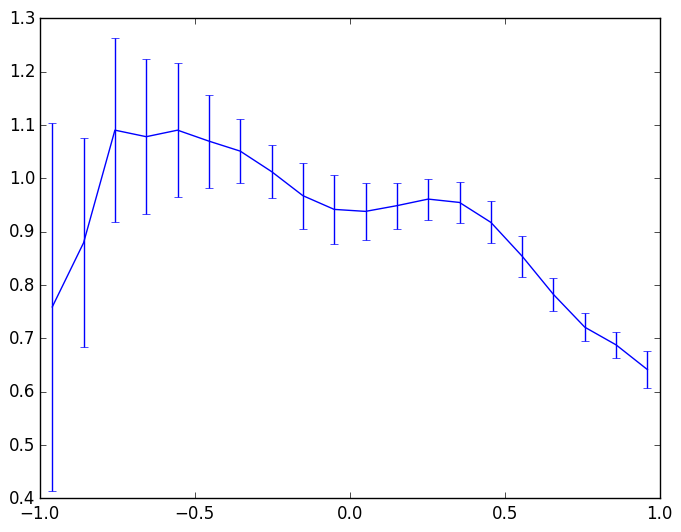

(PyObject <matplotlib.lines.Line2D object at 0x7fbafbadf6a0>,(PyObject <matplotlib.lines.Line2D object at 0x7fbafbad8b00>,PyObject <matplotlib.lines.Line2D object at 0x7fbafbad8eb8>),(PyObject <matplotlib.collections.LineCollection object at 0x7fbafbad8128>,))

In [20]:
errorbar(pitch,mf_iratio_mean,sqrt(mf_iratio_var))

In [21]:
using NetCDF
# Write synthetic data to file
fname = "data/mf_sampled_sawtooth.cdf"

isfile(fname) && rm(fname)

nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_a_mean_varid = NcVar("x_a_mean",[np_id,nen_id])
x_a_var_varid = NcVar("x_a_var",[np_id,nen_id])
x_a_bias_varid = NcVar("x_a_bias",[np_id,nen_id])

x_b_mean_varid = NcVar("x_b_mean",[np_id,nen_id])
x_b_var_varid = NcVar("x_b_var",[np_id,nen_id])
x_b_bias_varid = NcVar("x_b_bias",[np_id,nen_id])

x_ratio_mean_varid = NcVar("ratio_mean",[np_id,nen_id])
x_ratio_var_varid = NcVar("ratio_var",[np_id,nen_id])

iratio_mean_varid = NcVar("iratio_mean",np_id)
iratio_var_varid = NcVar("iratio_var",np_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[x_a_mean_varid,x_a_var_varid,x_a_bias_varid,
    x_b_mean_varid,x_b_var_varid,x_b_bias_varid,
    x_ratio_mean_varid,x_ratio_var_varid,
    iratio_mean_varid,iratio_var_varid,
    energy_varid,pitch_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_b_mean",mf_b_mean)
NetCDF.putvar(ncid,"x_b_var",mf_b_var)
NetCDF.putvar(ncid,"x_b_bias",mf_b_bias)

NetCDF.putvar(ncid,"x_a_mean",mf_a_mean)
NetCDF.putvar(ncid,"x_a_var",mf_a_var)
NetCDF.putvar(ncid,"x_a_bias",mf_a_bias)

NetCDF.putvar(ncid,"ratio_mean",mf_ratio_mean)
NetCDF.putvar(ncid,"ratio_var",mf_ratio_var)

NetCDF.putvar(ncid,"iratio_mean",mf_iratio_mean)
NetCDF.putvar(ncid,"iratio_var",mf_iratio_var)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid);

In [79]:
nr,nc = size(A_a)
num=50
x_a_samples = zeros(nc,num)
x_b_samples = zeros(nc,num)

@showprogress for i=1:num
    rA_b = A_b .+ dA.*randn(size(A_b)...)
    rA_a = A_a .+ dA.*randn(size(A_a)...)
    rspec_b = spec_b .+ err_b.*randn(size(spec_b)...)
    rspec_a = spec_a .+ err_a.*randn(size(spec_a)...)

    mf_before = EntropyFunctional(rA_b,rspec_b,err_b);
    mf_after  = EntropyFunctional(rA_a,rspec_a,err_a);
    alpha_before = lcurve(mf_before,log_alpha_range=(-15,-5),nseeds=25)
    alpha_after = lcurve(mf_after,log_alpha_range=(-15,-5),nseeds=25)
    sol_b = minimize(mf_before,alpha_before)
    sol_a = minimize(mf_after,alpha_after)
    x_b_samples[:,i] = max(sol_b.x,0)/(dE*dP)
    x_a_samples[:,i] = max(sol_a.x,0)/(dE*dP)
end

Progress: 100%|█████████████████████████████████████████| Time: 4:37:05


In [81]:
me_b_mean = reshape(mean(x_b_samples,2),20,20)
me_b_var  = reshape(var(x_b_samples,2),20,20)
me_b_bias = me_b_mean .- true_before

me_a_mean = reshape(mean(x_a_samples,2),20,20)
me_a_var  = reshape(var(x_a_samples,2),20,20)
me_a_bias = me_a_mean .- true_after

me_ratio_mean = reshape(mean(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)
me_ratio_var = reshape(var(max(x_a_samples,1e9)./max(x_b_samples,1e9),2),20,20)

iratio_samples = zeros(20,num)
for i=1:num
    aa = sqrt(sum(reshape(x_a_samples[:,i],20,20),2))./sum(reshape(x_b_samples[:,i],20,20),2)
    bb = sqrt(sum(reshape(x_a_samples[:,i],20,20),2))
    iratio_samples[:,i] = aa.*bb
end
me_iratio_mean = squeeze(mean(iratio_samples,2),2)
me_iratio_var = squeeze(var(iratio_samples,2),2);

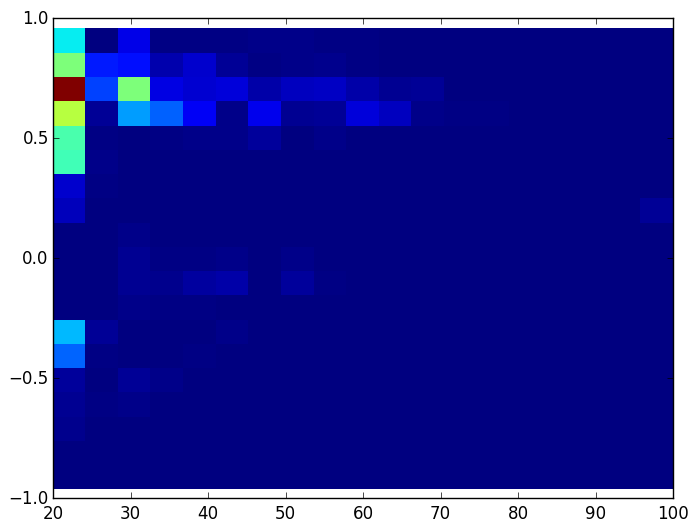

PyObject <matplotlib.collections.PolyCollection object at 0x7fbafaa76390>

In [91]:
pcolor(energy,pitch,me_b_var)

In [86]:
using NetCDF
# Write synthetic data to file
fname = "data/me_sampled_sawtooth.cdf"

isfile(fname) && rm(fname)

nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_a_mean_varid = NcVar("x_a_mean",[np_id,nen_id])
x_a_var_varid = NcVar("x_a_var",[np_id,nen_id])
x_a_bias_varid = NcVar("x_a_bias",[np_id,nen_id])

x_b_mean_varid = NcVar("x_b_mean",[np_id,nen_id])
x_b_var_varid = NcVar("x_b_var",[np_id,nen_id])
x_b_bias_varid = NcVar("x_b_bias",[np_id,nen_id])

x_ratio_mean_varid = NcVar("ratio_mean",[np_id,nen_id])
x_ratio_var_varid = NcVar("ratio_var",[np_id,nen_id])

iratio_mean_varid = NcVar("iratio_mean",np_id)
iratio_var_varid = NcVar("iratio_var",np_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[x_a_mean_varid,x_a_var_varid,x_a_bias_varid,
    x_b_mean_varid,x_b_var_varid,x_b_bias_varid,
    x_ratio_mean_varid,x_ratio_var_varid,
    iratio_mean_varid,iratio_var_varid,
    energy_varid,pitch_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_b_mean",me_b_mean)
NetCDF.putvar(ncid,"x_b_var",me_b_var)
NetCDF.putvar(ncid,"x_b_bias",me_b_bias)

NetCDF.putvar(ncid,"x_a_mean",me_a_mean)
NetCDF.putvar(ncid,"x_a_var",me_a_var)
NetCDF.putvar(ncid,"x_a_bias",me_a_bias)

NetCDF.putvar(ncid,"ratio_mean",me_ratio_mean)
NetCDF.putvar(ncid,"ratio_var",me_ratio_var)

NetCDF.putvar(ncid,"iratio_mean",me_iratio_mean)
NetCDF.putvar(ncid,"iratio_var",me_iratio_var)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid);

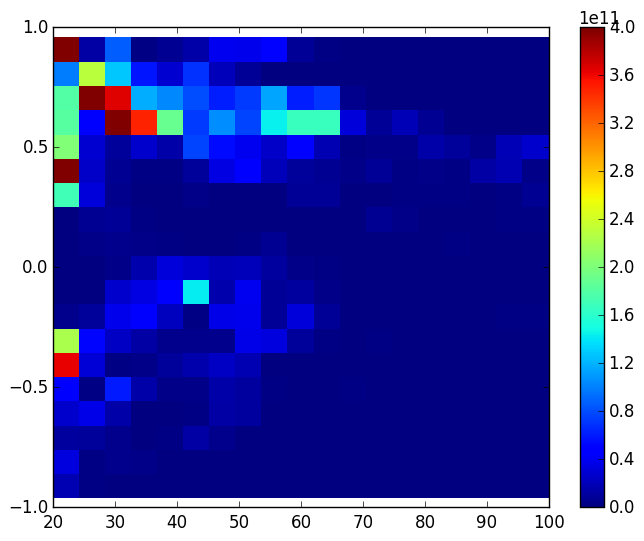

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbafb38f0b8>

In [54]:
pcolor(energy,pitch,me_a_mean,vmax=4e11)
colorbar()

In [110]:
using NetCDF
# Write synthetic data to file
fname = "data/true_sawtooth.cdf"

isfile(fname) && rm(fname)

nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_a_varid = NcVar("x_a",[np_id,nen_id])

x_b_varid = NcVar("x_b",[np_id,nen_id])

x_ratio_varid = NcVar("ratio",[np_id,nen_id])

iratio_varid = NcVar("iratio",np_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[x_a_varid,x_b_varid,
    x_ratio_varid,iratio_varid,energy_varid,pitch_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_b",true_before)

NetCDF.putvar(ncid,"x_a",true_after)

NetCDF.putvar(ncid,"ratio",ratio)

NetCDF.putvar(ncid,"iratio",iratio)


NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid);

In [107]:
iratio = squeeze(sum(true_after,2)./sum(true_before,2),2)
ratio = (sqrt(true_after)./max(true_before,1)).*sqrt(true_after)

20x20 Array{Float64,2}:
 0.880247  0.87033   1.09054   2.13279   7.31343   …  0.0       0.0  0.0  0.0
 0.782418  0.731004  0.980037  0.938758  0.980751     0.0       0.0  0.0  0.0
 0.989221  0.826849  0.836867  1.20818   0.93269      0.0       0.0  0.0  0.0
 0.892626  0.970255  0.947302  1.05628   1.11531      0.0       0.0  0.0  0.0
 0.921018  0.953716  1.05702   0.860786  1.1368       0.0       0.0  0.0  0.0
 1.02512   1.00206   1.04906   1.05547   1.26221   …  0.0       0.0  0.0  0.0
 0.917293  0.972097  0.970073  1.0329    1.32814      0.0       0.0  0.0  0.0
 0.947762  0.959162  1.00144   1.08856   1.0593       0.0       0.0  0.0  0.0
 0.903424  0.913123  0.998205  0.891216  0.900977     0.0       0.0  0.0  0.0
 0.897848  0.883957  0.90257   0.811703  0.758974     0.0       0.0  0.0  0.0
 0.885299  0.799019  0.793633  0.740074  0.681666  …  0.0       0.0  0.0  0.0
 0.859111  0.746103  0.702662  0.703692  0.618974     0.0       0.0  0.0  0.0
 0.830779  0.728623  0.659942  0.75168  

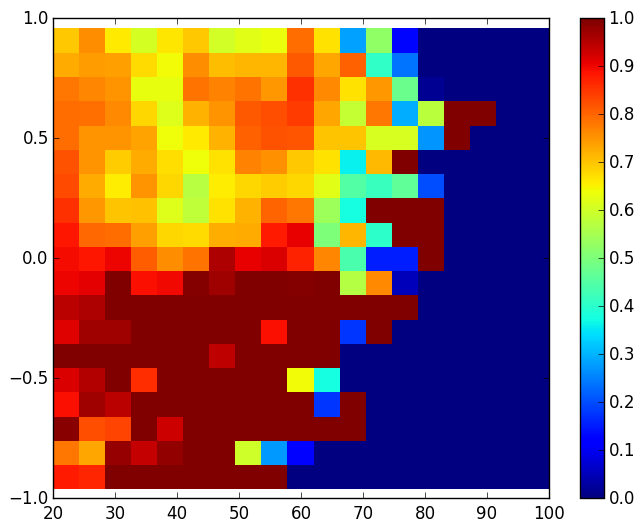

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbafa8e2780>

In [108]:
pcolor(energy,pitch,ratio,vmax=1)
colorbar()

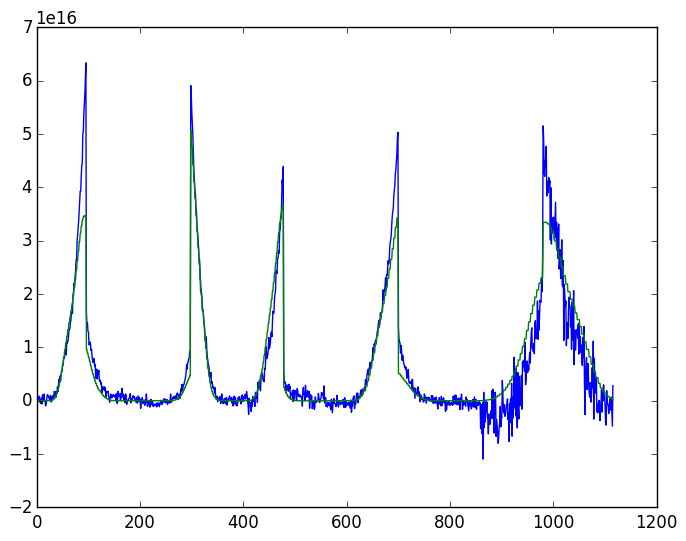

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbafa4d1ef0>

In [125]:
t_b = bilinear(true_dist["TRANSP_before"],true_dist["E"],true_dist["p"],a["E"],a["p"])
plot(spec_b)
plot(A_b_full*vec(t_b)*dS)

In [118]:
dS=(abs(energy_full_A[2]-energy_full_A[1])*abs(pitch_full_A[2]-pitch_full_A[1]))

0.06397331846301313